In [1]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import random
import seaborn as sns

from Functions import prep_training_test_data_period, prep_training_test_data, calculate_metrics,cross_validation_leave_geo_out, prep_training_test_data_shifted, add_labels_to_subplots
hfont = {'fontname':'Helvetica'}
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']


# Load data


In [2]:
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly.csv")

# Parameters needed for CV

In [3]:
no_iterations = 100
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'period'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1
train_weeks_for_initial_model = 1

weeks_in_future = 3 
weight_col = 'weight'  
keep_output = False  

no_iterations_param = 20  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

# Functions

# Naive dataset

In [4]:
columns_to_select = HSA_weekly_data_all.filter(regex="HSA|beds_over_15_100k|weight").columns.tolist()
naive_data = HSA_weekly_data_all[columns_to_select]

In [706]:
weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)
ROC_by_week_naive_period = []
sensitivity_by_week_naive_period = []
specificity_by_week_naive_period = []
ppv_by_week_naive_period = []
npv_by_week_naive_period = []
accuracy_by_week_naive_period = []
norm_MCC_by_week_naive_period = []

ROC_by_week_naive_exact = []
sensitivity_by_week_naive_exact = []
specificity_by_week_naive_exact = []
ppv_by_week_naive_exact = []
npv_by_week_naive_exact = []
accuracy_by_week_naive_exact = []
norm_MCC_by_week_naive_exact = []

ROC_by_week_naive_shifted = []
sensitivity_by_week_naive_shifted = []
specificity_by_week_naive_shifted = []
ppv_by_week_naive_shifted = []
npv_by_week_naive_shifted = []
accuracy_by_week_naive_shifted = []
norm_MCC_by_week_naive_shifted = []



net_benefit_by_model_omega_p_period  = {}
net_benefit_by_model_omega_p_exact  = {}
net_benefit_by_model_omega_p_shifted  = {}


omega_sequences = np.linspace(0,1,9)
threshold_sequences = np.linspace(0,1,101)

size_of_test_dataset = 1
for prediction_week in weeks_to_predict:
    print(prediction_week)
    print(range(1 , int(prediction_week + train_weeks_for_initial_model) + 1))
    print(range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1))
    #period    

    X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data_period(naive_data, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    

    X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data_period(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_naive = weights_naive[0].to_numpy()
    # no hyperparameter tuning as is the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier( random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive)
    y_pred_proba = clf_naive.predict_proba(X_test_naive)

    # Evaluate the accuracy of the model
    accuracy_by_week_naive_period.append(accuracy_score(y_test_naive, y_pred))
    ROC_by_week_naive_period.append(roc_auc_score(y_test_naive, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_naive, y_pred)

    sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_naive_period.append(sensitvity)
    specificity_by_week_naive_period.append(specificity)

    ppv_by_week_naive_period.append(ppv)
    npv_by_week_naive_period.append(npv)

    norm_MCC_by_week_naive_period.append((matthews_corrcoef(y_test_naive, y_pred) + 1)/2)

    net_benefit_by_omega_week_period = find_net_benefit(y_pred_proba, y_test_naive, omega_sequences, threshold_sequences)
    net_benefit_by_model_omega_p_period.__setitem__(prediction_week, net_benefit_by_omega_week_period)

    #exact 
    X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data(naive_data, no_weeks = range(1 , int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_naive = weights_naive[0].to_numpy()
    # no hyperparameter tuning as it's the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier(random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive)
    y_pred_proba = clf_naive.predict_proba(X_test_naive)

    # Evaluate the accuracy of the model
    accuracy_by_week_naive_exact.append(accuracy_score(y_test_naive, y_pred))
    ROC_by_week_naive_exact.append(roc_auc_score(y_test_naive, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_naive, y_pred)

    sensitivity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_naive_exact.append(sensitivity)
    specificity_by_week_naive_exact.append(specificity)

    ppv_by_week_naive_exact.append(ppv)
    npv_by_week_naive_exact.append(npv)
    norm_MCC_by_week_naive_exact.append((matthews_corrcoef(y_test_naive, y_pred) + 1)/2)

    net_benefit_by_omega_week_exact = find_net_benefit(y_pred_proba, y_test_naive, omega_sequences, threshold_sequences)
    net_benefit_by_model_omega_p_exact.__setitem__(prediction_week, net_benefit_by_omega_week_exact)

    # shifted
    X_train_naive_shifted, y_train_naive_shifted, weights_naive_shifted, missing_data_train_HSA = prep_training_test_data_shifted(naive_data, no_weeks=range(1 , int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_naive_shifted, y_test_naive_shifted, weights_test_naive_shifted, missing_data_test_HSA = prep_training_test_data_shifted(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_naive_shifted = weights_naive_shifted[0].to_numpy()
    # no hyperparameter tuning as it's the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier(random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive_shifted, y_train_naive_shifted, sample_weight=weights_naive_shifted)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive_shifted)
    y_pred_proba = clf_naive.predict_proba(X_test_naive_shifted)
    net_benefit_by_omega_week_shifted = find_net_benefit(y_pred_proba, y_test_naive_shifted, omega_sequences, threshold_sequences)
    net_benefit_by_model_omega_p_shifted.__setitem__(prediction_week, net_benefit_by_omega_week_shifted)     


1
range(1, 3)
range(3, 4)


NameError: name 'find_net_benefit' is not defined

In [5]:
num_shades = 120
blue_shades = []

# Generate the shades of blue
for i in range(num_shades):
    # Vary the blue component from 0 (dark) to 1 (full intensity)
    blue_intensity = i / (num_shades - 1)
    # Create the RGB color tuple with full blue intensity and no red or green
    color = (0, 0, blue_intensity)
    blue_shades.append(color)

In [6]:
heatmap_data_omega_0 = pd.DataFrame()
omega = omega_sequences[0]
for week in range( 1, weeks_to_predict[-1],1 ):
        weekly_data = net_benefit_by_model_omega_p_period[week][omega]
        weekly_data = weekly_data[::-1]
        heatmap_data_omega_0[week] = weekly_data

def get_heatmap_data_for_omega(NB_data, omega, weeks_to_predict):
        heatmap_data_omega = pd.DataFrame()
        for week in range( 1, weeks_to_predict[-1],1 ):
                weekly_data = NB_data[week][omega]
                weekly_data = weekly_data[::-1]
                heatmap_data_omega[week] = weekly_data
        return heatmap_data_omega


NameError: name 'omega_sequences' is not defined

In [7]:
heatmap = sns.heatmap(heatmap_data_omega_0, annot=False, cmap='Purples')
heatmap.set_yticks(range(0, 91, 10))
y_labels = [str(round(0.1 * i,1)) for i in range(1, 11)][::-1] # Example x-axis labels
heatmap.set_yticklabels(y_labels)


heatmap.set_xticks(range(1, 120, 5))
x_labels = range(1, 120, 5) 
heatmap.set_xticklabels(x_labels, rotation=45)  # Rotation to 0 degrees

plt.xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18)
plt.ylabel("Classification Threshold",**hfont,  fontsize = 18)
plt.title(f'Penalty = {omega}')


ValueError: zero-size array to reduction operation fmin which has no identity

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_16495/2685266758.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  heatmap_data_omega[week] = weekly_data
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_16495/2685266758.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  heatmap_data_omega[week] = weekly_data
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_16495/2685266758.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

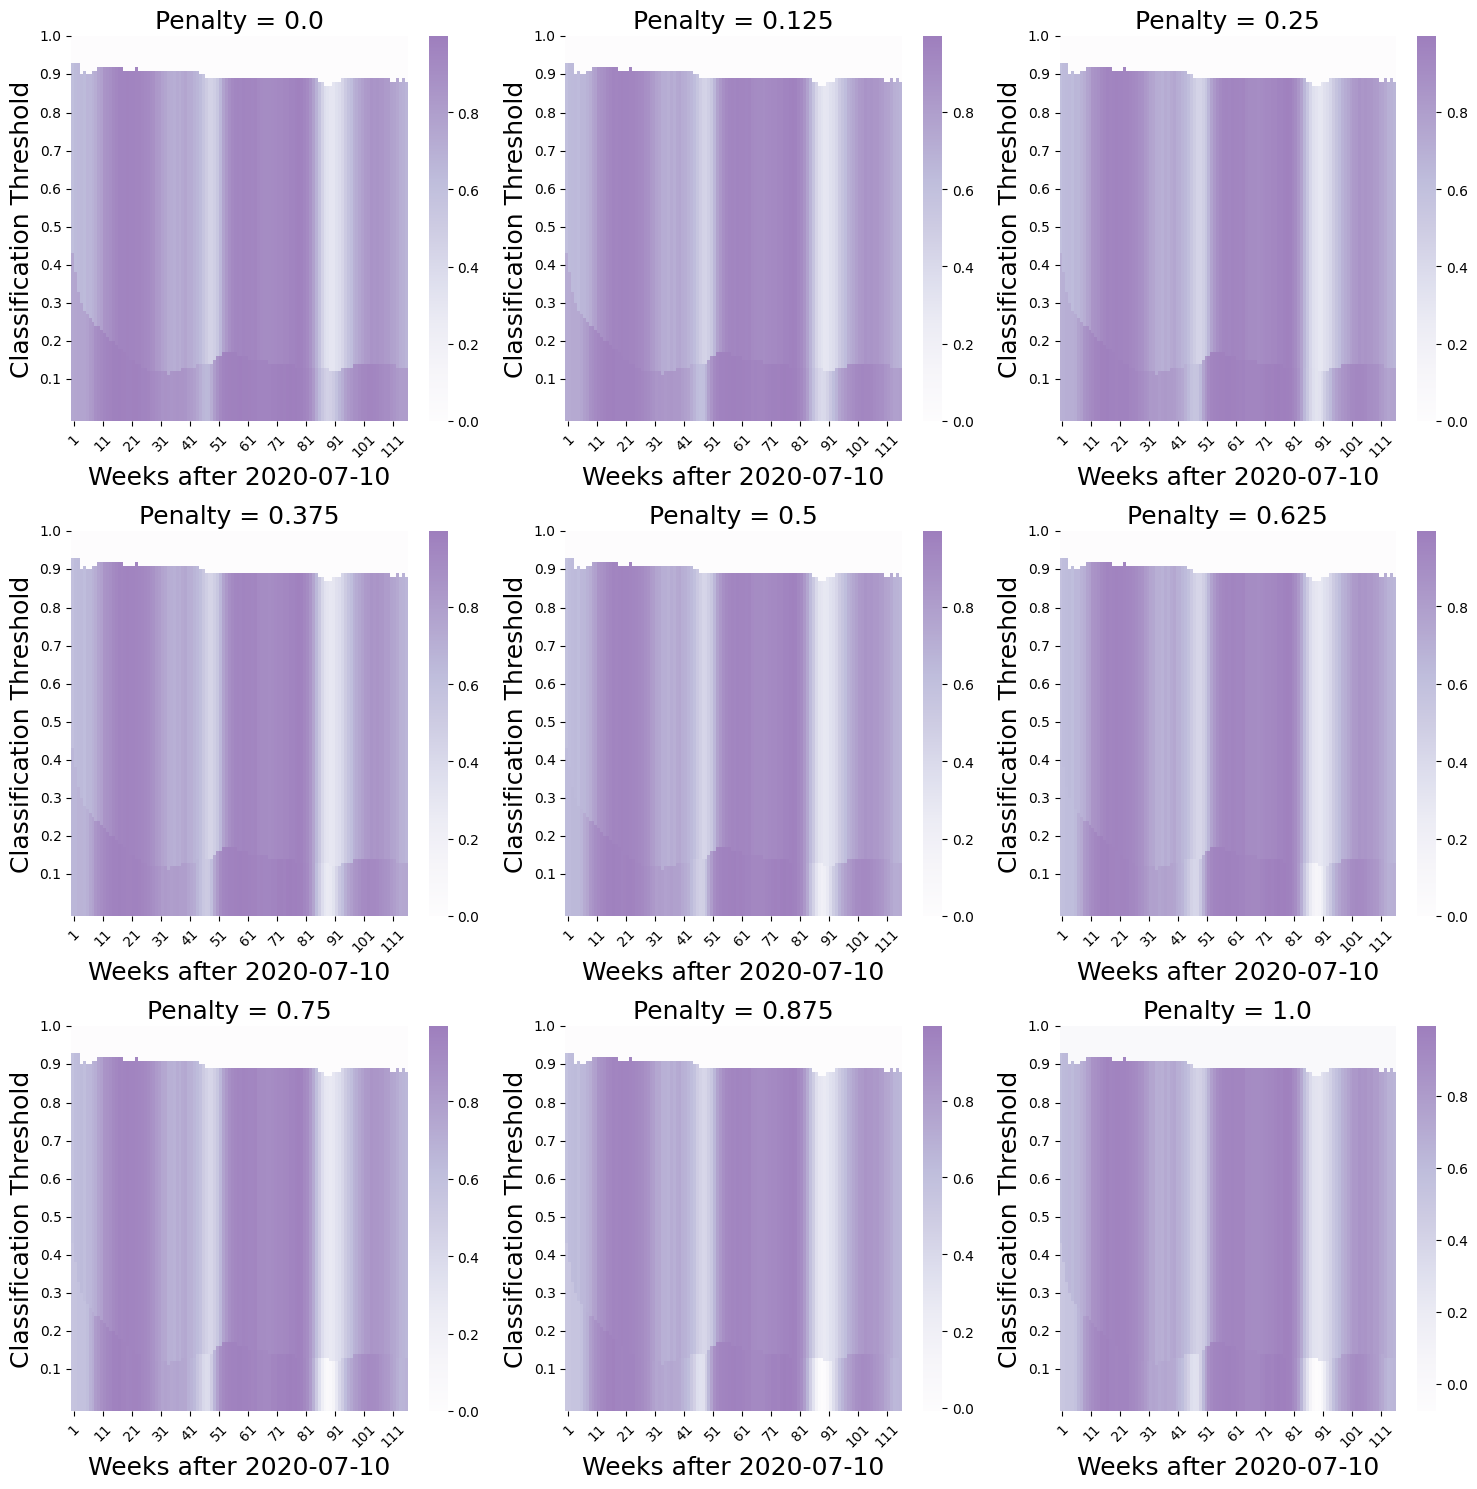

In [225]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)

# Iterate over omega values and create a heatmap for each
for i, omega in enumerate(omega_sequences):
    row, col = divmod(i, 3)  # Calculate row and column indices
    ax = axes[row, col]  # Get the current subplot
    
    # Create the heatmap for the current omega value
    heatmap_data_naive_period = get_heatmap_data_for_omega(net_benefit_by_model_omega_p_period, omega, weeks_to_predict);  # Replace with your actual data retrieval function
    sns.heatmap(heatmap_data_naive_period, annot=False, cmap='Purples', ax=ax, alpha = 0.5) #  vmin=-1, vmax=1)
    ax.set_yticks(range(0, 91, 10))
    y_labels = [str(round(0.1 * i, 1)) for i in range(1, 11)][::-1]
    ax.set_yticklabels(y_labels)
    ax.set_xticks(range(1, 120, 10))
    x_labels = range(1, 120, 10)
    ax.set_xticklabels(x_labels, rotation=45)
    
    ax.set_xlabel('Weeks after 2020-07-10', fontsize=18)
    ax.set_ylabel("Classification Threshold", fontsize=18)
    ax.set_title(f'Penalty = {omega}', fontsize=18)

# Adjust the spacing between subplots
plt.tight_layout()
plt.savefig('/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Benefit_naive_model_period.png', dpi = 300)


# Full classifier

Calculate net benefit and other performance metrics

In [8]:
import os
import pickle
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, matthews_corrcoef

new_directory = '/Users/rem76/Documents/COVID_projections/Expanding_training_set/'
os.chdir(new_directory)

net_benefit_by_omega_p_full_period = {}
ROC_by_week_full_period = []
sensitivity_by_week_full_period = []
specificity_by_week_full_period = []
ppv_by_week_full_period = []
npv_by_week_full_period = []
accuracy_by_week_full_period = []
norm_MCC_by_week_full_period = []

size_of_test_dataset = 1

for prediction_week in weeks_to_predict:
    model_name_to_load = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data_period(
        HSA_weekly_data_all, 
        no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), 
        weeks_in_future=3, 
        geography='HSA_ID', 
        weight_col='weight', 
        keep_output=True
    )

    X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data_period(
        HSA_weekly_data_all, 
        no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), 
        weeks_in_future=3, 
        geography='HSA_ID', 
        weight_col='weight', 
        keep_output=True
    )
    
    weights_full_period = weights_full[0].to_numpy()

    clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full_period)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full)
    y_pred_proba = clf_full_period.predict_proba(X_test_full)
    y_pred_positive_proba = y_pred_proba[:, 1] 

    net_benefit_by_omega_week_period = find_net_benefit(y_pred_proba, y_test_full, omega_sequences, threshold_sequences)
    net_benefit_by_omega_p_full_period[prediction_week] = net_benefit_by_omega_week_period

    ROC_by_week_full_period.append(roc_auc_score(y_test_full, y_pred_positive_proba))
    conf_matrix = confusion_matrix(y_test_full, y_pred)

    sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_full_period.append(sensitvity)
    specificity_by_week_full_period.append(specificity)
    ppv_by_week_full_period.append(ppv)
    npv_by_week_full_period.append(npv)

    accuracy_by_week_full_period.append(accuracy_score(y_test_full, y_pred))
    norm_MCC_by_week_full_period.append((matthews_corrcoef(y_test_full, y_pred) + 1) / 2)



NameError: name 'weeks_to_predict' is not defined

Plot performance metrics

In [ ]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 7.5), sharey = 'all')

# Plot data on the same plot
axs.plot(weeks_to_predict, ROC_by_week_full_period, label='auROC', linewidth = 3, color = palette[0])
axs.plot(weeks_to_predict, norm_MCC_by_week_full_period, label='MCC', linewidth = 3, color = palette[1])
axs.plot(weeks_to_predict, accuracy_by_week_full_period, label='Accuracy', linewidth = 3, color = palette[5])



# Add labels and legend
axs.set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )

axs.set_ylabel('Performance score',**hfont,  fontsize = 18)
axs.tick_params(axis='both', which='major', labelsize=12)

#add_labels_to_subplots(axs, hfont, 1.01, 24)
axs.legend(ncol = 2, loc='lower left')

Plot net benefit

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_16495/2685266758.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  heatmap_data_omega[week] = weekly_data
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_16495/2685266758.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  heatmap_data_omega[week] = weekly_data
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_16495/2685266758.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

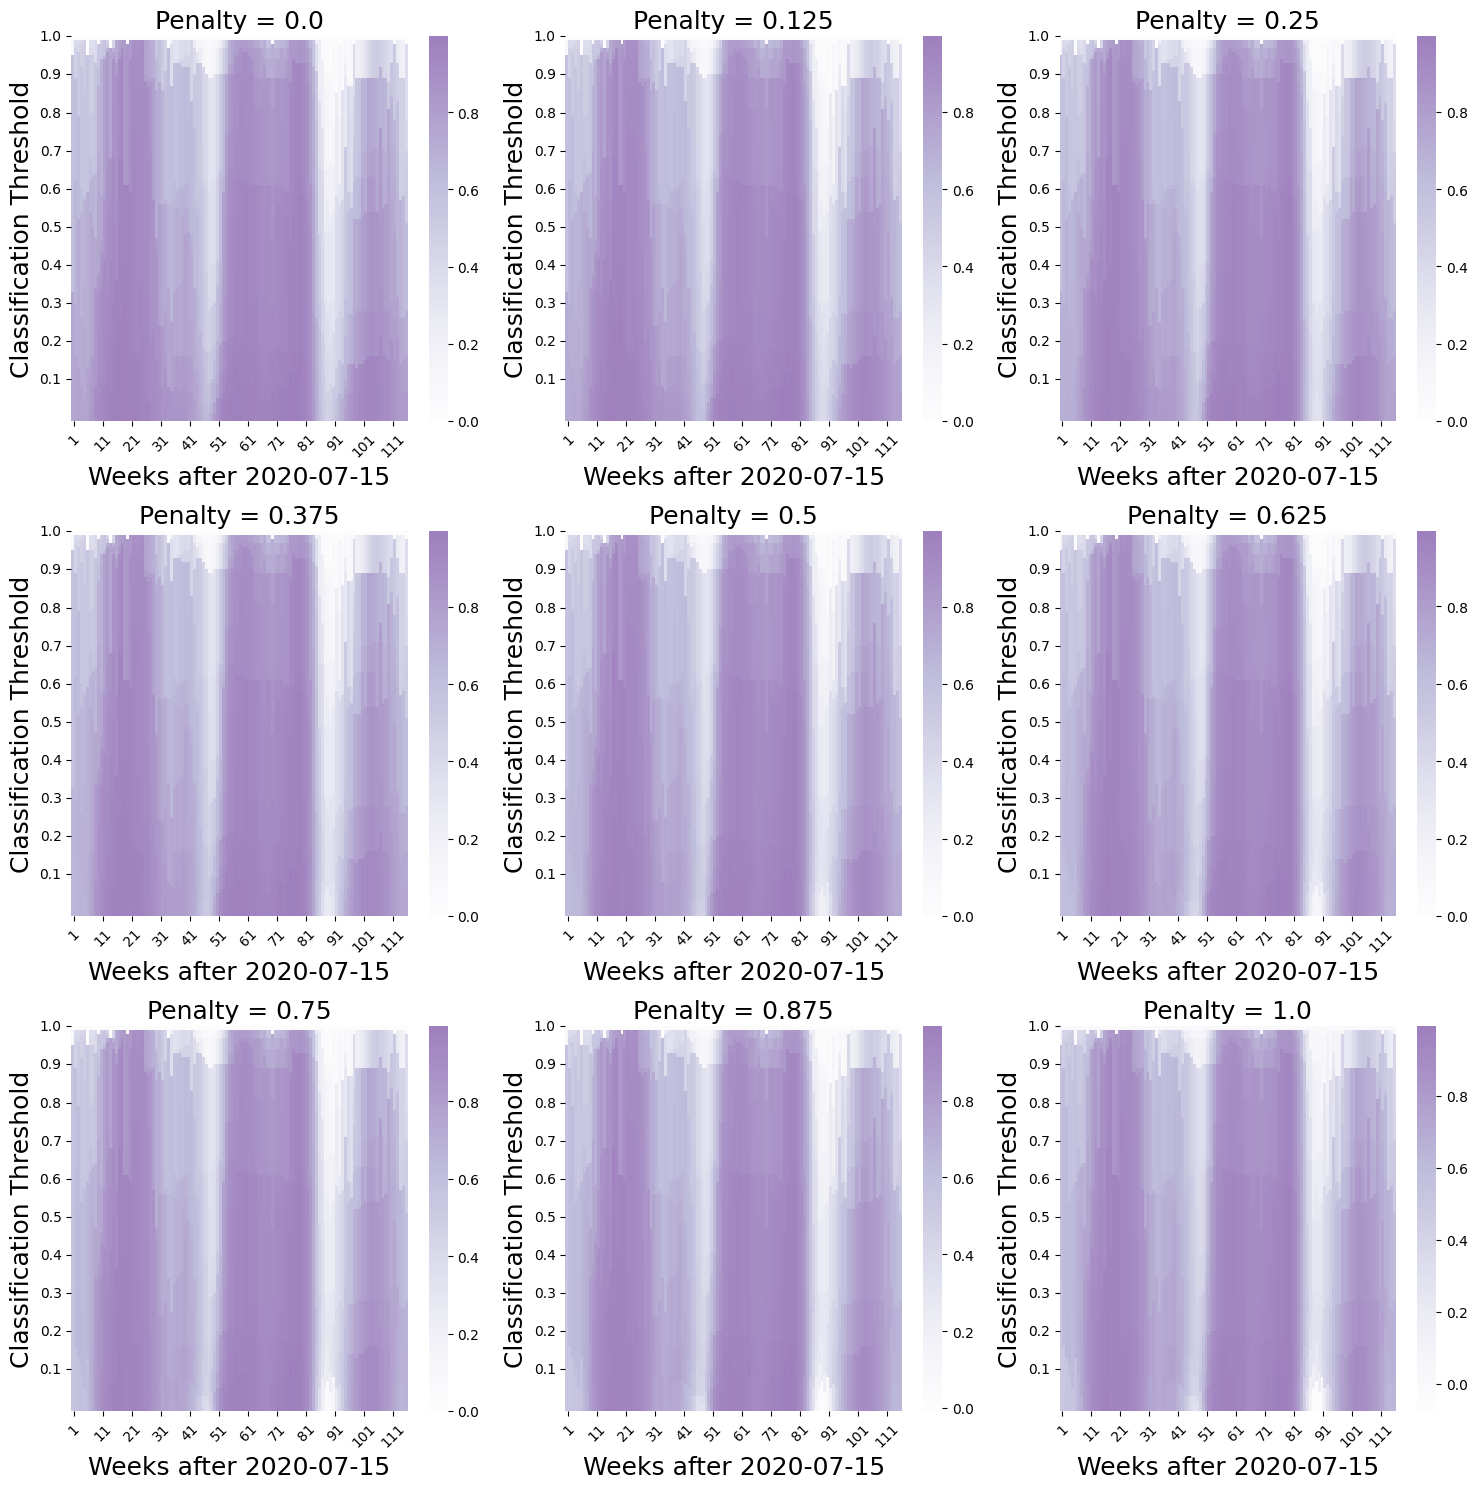

In [224]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over omega values and create a heatmap for each
for i, omega in enumerate(omega_sequences):
    row, col = divmod(i, 3)  # Calculate row and column indices
    ax = axes[row, col]  # Get the current subplot
    
    # Create the heatmap for the current omega value
    heatmap_data_full_period = get_heatmap_data_for_omega(net_benefit_by_omega_p_full_period, omega, weeks_to_predict);  # Replace with your actual data retrieval function
    sns.heatmap(heatmap_data_full_period, annot=False, cmap='Purples', ax=ax, alpha = 0.5) #  vmin=-1, vmax=1)
    ax.set_yticks(range(0, 91, 10))
    y_labels = [str(round(0.1 * i, 1)) for i in range(1, 11)][::-1]
    ax.set_yticklabels(y_labels)
    ax.set_xticks(range(1, 120, 10))
    x_labels = range(1, 120, 10)
    ax.set_xticklabels(x_labels, rotation=45)
    
    ax.set_xlabel('Weeks after 2020-07-15', fontsize=18)
    ax.set_ylabel("Classification Threshold", fontsize=18)
    ax.set_title(f'Penalty = {omega}', fontsize=18)

# Adjust the spacing between subplots
plt.tight_layout()
plt.savefig('/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Benefit_full_model_period.png', dpi = 300)


# Important features in expanding models

In [205]:
feature_names=['Cases','\u0394 Cases', 'Deaths', '\u0394 Deaths', 'Admissions', '\u0394 Admissions', 'ICU', '\u0394 ICU',  'Beds', '\u0394 Beds', 'Percent of beds', '\u0394 Perc. beds', 'Exceeded capacity']
num_features = len(feature_names)

# Initialize a dictionary to store feature importance counts
feature_importance_counts = {feature_name: 0 for feature_name in feature_names}

# Loop through iterations
for prediction_week in weeks_to_predict:
    # Create the training data
    X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    weights_full_period = weights_full_period[0].to_numpy()
    
    # Load and train the model 
    model_name = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"

    clf_full_period = pickle.load(open(model_name, 'rb'))
    clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)

    # Get feature importances for this iteration
    feature_importances = clf_full_period.feature_importances_
    
    # Update the counts for each feature
    for feature_idx, importance in enumerate(feature_importances):
        if importance > 0:
            feature_name = feature_names[feature_idx]
            feature_importance_counts[feature_name] += 1

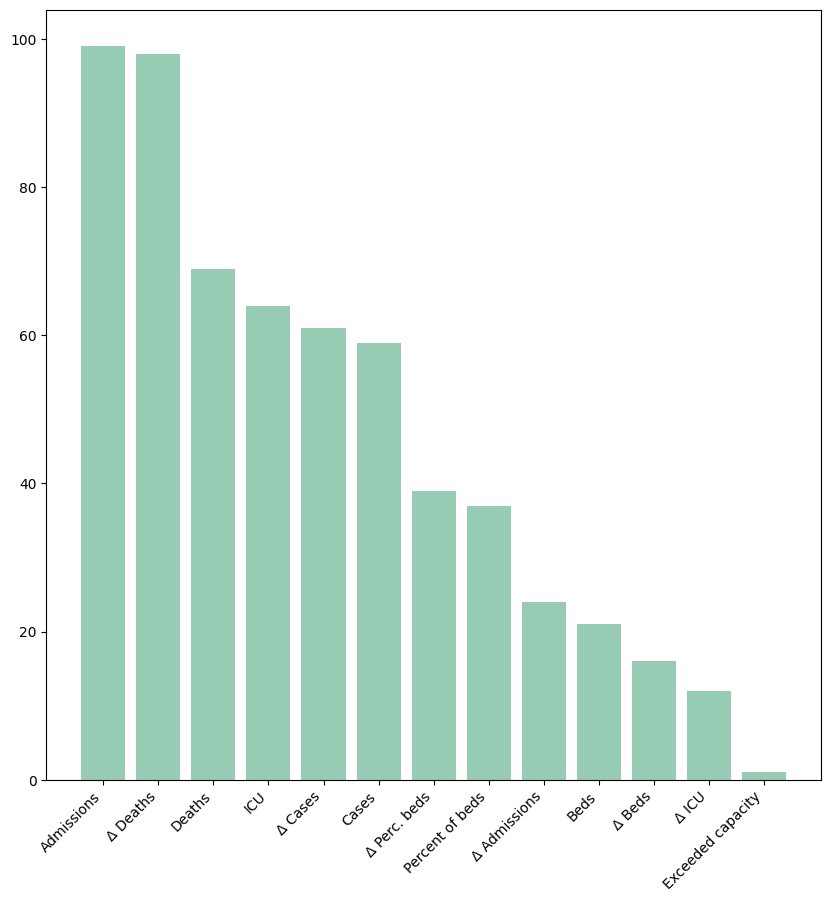

In [206]:
fig, axs = plt.subplots(1,1, figsize=(10, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

sorted_feature_importance_counts = dict(sorted(feature_importance_counts.items(), key=lambda item: item[1], reverse=True))

plt.bar(sorted_feature_importance_counts.keys(), sorted_feature_importance_counts.values(), color = '#98CBB4')

plt.xticks(rotation=45, ha='right')

plt.savefig('/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Included_features_expanding_models_full_period.png', dpi = 300)



# Shapley calculation

In [9]:
import shap
shap_values_list = []

mean_shapley_values = []

size_of_test_dataset = 1
weeks_to_predict = range(1,117)
for prediction_week in weeks_to_predict:
    model_name_to_load = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    print(prediction_week)

    #period    

    X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full = weights_full[0].to_numpy()
    clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full)
    y_pred_proba = clf_full_period.predict_proba(X_test_full)
        # Compute Shapley values for the current prediction
    explainer = shap.Explainer(clf_full_period)
    shap_values = explainer.shap_values(X_test_full)
    # Calculate the mean Shapley value importance

    mean_shapley_value = np.mean(shap_values[1], axis=0)
    mean_shapley_values.append(mean_shapley_value)
    #shap.summary_plot(shap_values[1], X_test_full, plot_type="bar", feature_names= feature_names)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116


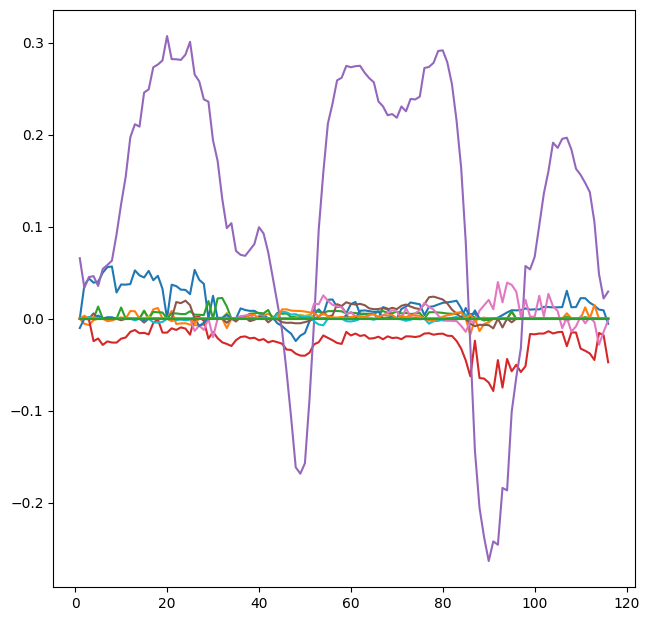

<Figure size 1200x600 with 0 Axes>

In [709]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 7.5), sharey = 'all')

feature_names = ['Cases','Δ Cases', 'Deaths', 'Δ Deaths', 'Admissions', 'Δ Admissions', 'ICU', 'Δ ICU',  'Beds', 'Δ Beds', 'Percent of beds', 'Δ Perc. beds', 'Hospital capacity exceeded']

#for i, feature in enumerate(feature_names):
#    axs.plot(weeks_to_predict, mean_shapley_values[i], linestyle='-', label = feature)
plt.plot(weeks_to_predict, mean_shapley_values, linestyle='-')
# Create a line chart to visualize feature importance
plt.figure(figsize=(12, 6))
#plt.plot(weeks_to_predict, mean_shapley_values, marker='o', linestyle='-')

plt.show()




In [10]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

print_feature_importances_shap_values(shap_values, feature_names)

NameError: name 'feature_names' is not defined

Prediction Week: 1
Prediction Week: 2
Prediction Week: 3
Prediction Week: 4
Prediction Week: 5
Prediction Week: 6
Prediction Week: 7
Prediction Week: 8
Prediction Week: 9
Prediction Week: 10
Prediction Week: 11
Prediction Week: 12
Prediction Week: 13
Prediction Week: 14
Prediction Week: 15
Prediction Week: 16
Prediction Week: 17
Prediction Week: 18
Prediction Week: 19
Prediction Week: 20
Prediction Week: 21
Prediction Week: 22
Prediction Week: 23
Prediction Week: 24
Prediction Week: 25
Prediction Week: 26
Prediction Week: 27
Prediction Week: 28
Prediction Week: 29
Prediction Week: 30
Prediction Week: 31
Prediction Week: 32
Prediction Week: 33
Prediction Week: 34
Prediction Week: 35
Prediction Week: 36
Prediction Week: 37
Prediction Week: 38
Prediction Week: 39
Prediction Week: 40
Prediction Week: 41
Prediction Week: 42
Prediction Week: 43
Prediction Week: 44
Prediction Week: 45
Prediction Week: 46
Prediction Week: 47
Prediction Week: 48
Prediction Week: 49
Prediction Week: 50
Predictio

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


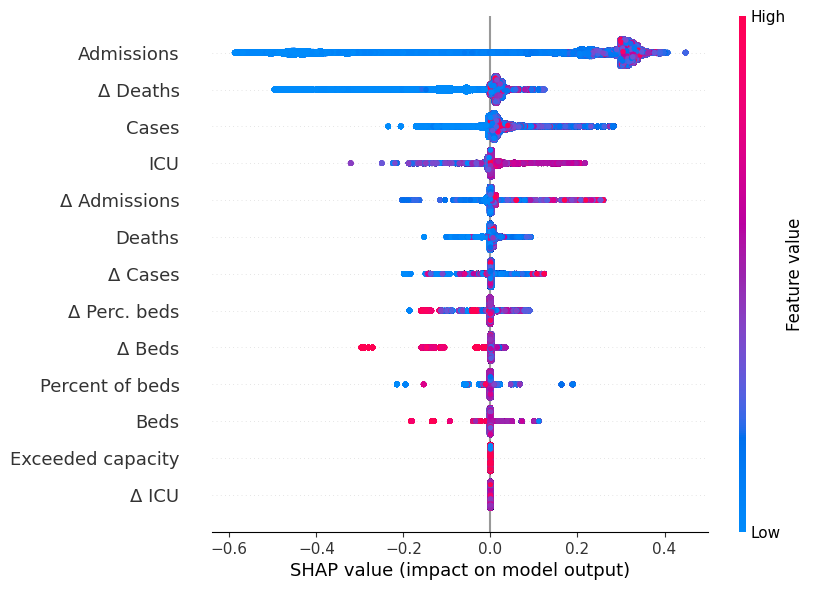

<Figure size 640x480 with 0 Axes>

In [14]:

feature_names=['Cases','\u0394 Cases', 'Deaths', '\u0394 Deaths', 'Admissions', '\u0394 Admissions', 'ICU', '\u0394 ICU',  'Beds', '\u0394 Beds', 'Percent of beds', '\u0394 Perc. beds', 'Exceeded capacity']
# Initialize empty lists to store mean Shapley values and prediction weeks
mean_shapley_values = []
prediction_weeks = []

size_of_test_dataset = 1
weeks_to_predict_sample = range(1,11)

for prediction_week in weeks_to_predict:
    model_name_to_load = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    print(f"Prediction Week: {prediction_week}")
    X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full = weights_full[0].to_numpy()
    # Fit the model
    clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full)

    X_test_full.columns = feature_names

    explainer = shap.TreeExplainer(clf_full_period)
    shap_values = explainer.shap_values(X_test_full)
    #shap.summary_plot(shap_values, features = X_test_full.columns)
    explainer = shap.Explainer(clf_full_period)
    shap_values = explainer(X_test_full)
    # Concatenate all values
    if prediction_week == weeks_to_predict[0]:
        shap_values_all = shap_values
    else:
        for feature in X_test_full.columns: 
                shap_values_all.values = np.concatenate([shap_values_all.values, shap_values.values])
                shap_values_all.base_values = np.concatenate([shap_values_all.base_values, shap_values.base_values])
                shap_values_all.data = np.concatenate([shap_values_all.data, shap_values.data])


shap.plots.beeswarm(shap_values_all[:,:,1], max_display=14)
    #shap.summary_plot(shap_values, X_test_full, plot_type="bar", feature_names= feature_names)
plt.savefig(f'/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/SHAP_values_full_expanding_train_models_period_{size_of_test_dataset}_week.png', dpi = 300)


Prediction Week: 1
Prediction Week: 2
Prediction Week: 3
Prediction Week: 4
Prediction Week: 5
Prediction Week: 6
Prediction Week: 7
Prediction Week: 8
Prediction Week: 9
Prediction Week: 10
Prediction Week: 11
Prediction Week: 12
Prediction Week: 13
Prediction Week: 14
Prediction Week: 15
Prediction Week: 16
Prediction Week: 17
Prediction Week: 18
Prediction Week: 19
Prediction Week: 20
Prediction Week: 21
Prediction Week: 22
Prediction Week: 23
Prediction Week: 24
Prediction Week: 25
Prediction Week: 26
Prediction Week: 27
Prediction Week: 28
Prediction Week: 29
Prediction Week: 30
Prediction Week: 31
Prediction Week: 32
Prediction Week: 33
Prediction Week: 34
Prediction Week: 35
Prediction Week: 36
Prediction Week: 37
Prediction Week: 38
Prediction Week: 39
Prediction Week: 40
Prediction Week: 41
Prediction Week: 42
Prediction Week: 43
Prediction Week: 44
Prediction Week: 45
Prediction Week: 46
Prediction Week: 47
Prediction Week: 48
Prediction Week: 49
Prediction Week: 50
Predictio

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.


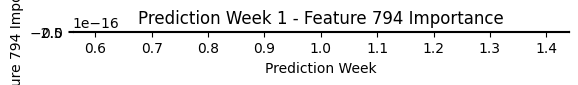

In [12]:

# Initialize empty lists to store mean Shapley values and prediction weeks
mean_shapley_values = []
prediction_weeks = []

size_of_test_dataset = 1
for prediction_week in weeks_to_predict:
    model_name_to_load = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    print(f"Prediction Week: {prediction_week}")

    # Replace with your data preparation functions
    # Example: X_train_full, y_train_full, weights_full = prep_training_data()

    # Fit the model
    clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full)

    # Calculate Shapley values
    explainer = shap.Explainer(clf_full_period)
    shap_values = explainer.shap_values(X_test_full)

    # Calculate the mean Shapley value importance
    mean_shapley_value = np.mean(shap_values, axis=0)
    mean_shapley_values.append(mean_shapley_value)
    prediction_weeks.append(prediction_week)

prediction_weeks = [1]
# Convert to numpy arrays
mean_shapley_values = np.array(mean_shapley_values)
prediction_weeks = np.array(prediction_weeks)

# Create subplots for each prediction week
num_prediction_weeks = len(weeks_to_predict)
num_features = mean_shapley_values.shape[1]
num_prediction_weeks = 1

for i in range(num_prediction_weeks):
    plt.subplot(num_features, num_prediction_weeks, i + 1)

    for j in range(num_features):
        plt.bar(prediction_weeks[i], mean_shapley_values[i, j])
        plt.xlabel("Prediction Week")
        plt.ylabel(f"Feature {j + 1} Importance")
        plt.title(f"Prediction Week {weeks_to_predict[i]} - Feature {j + 1} Importance")

plt.tight_layout()
plt.show()



# Find optimum p for a given omega

In [682]:
omega_sequences = np.linspace(0,1,9)
threshold_sequences = np.linspace(0,1,101)


In [697]:
import os
import pickle
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, matthews_corrcoef

new_directory = '/Users/rem76/Documents/COVID_projections/Expanding_training_set/'
os.chdir(new_directory)

ROC_by_week_full_period = []
sensitivity_by_week_full_period = []
specificity_by_week_full_period = []
ppv_by_week_full_period = []
npv_by_week_full_period = []
accuracy_by_week_full_period = []
norm_MCC_by_week_full_period = []

size_of_test_dataset = 1
weeks_to_predict = [76]
for prediction_week in weeks_to_predict:
    model_name_to_load = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data_period(
        HSA_weekly_data_all, 
        no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), 
        weeks_in_future=3, 
        geography='HSA_ID', 
        weight_col='weight', 
        keep_output=True
    )

    X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data_period(
        HSA_weekly_data_all, 
        no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), 
        weeks_in_future=3, 
        geography='HSA_ID', 
        weight_col='weight', 
        keep_output=True
    )
    
    weights_full_period = weights_full[0].to_numpy()

    clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full_period)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full)
    y_pred_proba = clf_full_period.predict_proba(X_test_full)
    y_pred_positive_proba = y_pred_proba[:, 1] 

    ROC_by_week_full_period.append(roc_auc_score(y_test_full, y_pred_positive_proba))
    conf_matrix = confusion_matrix(y_test_full, y_pred)

    sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_full_period.append(sensitvity)
    specificity_by_week_full_period.append(specificity)
    ppv_by_week_full_period.append(ppv)
    npv_by_week_full_period.append(npv)

    accuracy_by_week_full_period.append(accuracy_score(y_test_full, y_pred))
    norm_MCC_by_week_full_period.append((matthews_corrcoef(y_test_full, y_pred) + 1) / 2)


In [699]:
for omega in omega_sequences:
    max_net_benefit = float('-inf')  # Initialize with negative infinity
    best_p = None
    
    for p in threshold_sequences:
        y_predict_test = np.where(y_pred_proba[:, 1] > p, 1, 0)
        tn, fp, fn, tp = confusion_matrix(y_true=y_test_full, y_pred=y_predict_test).ravel()

        net_benefit = tp / len(y_test_full) - (fp / len(y_test_full)) * omega
    
        if net_benefit > max_net_benefit:
            max_net_benefit = net_benefit
            best_p = p
        #print(net_benefit)
    print("p:", p)
    print("p*:", omega/(1 + omega))

p: 1.0
p*: 0.0
p: 1.0
p*: 0.1111111111111111
p: 1.0
p*: 0.2
p: 1.0
p*: 0.2727272727272727
p: 1.0
p*: 0.3333333333333333
p: 1.0
p*: 0.38461538461538464
p: 1.0
p*: 0.42857142857142855
p: 1.0
p*: 0.4666666666666667
p: 1.0
p*: 0.5
